In [1]:
## New notebook to carry out some of the trickier analysis on binned intensity ##
# GOAL: Would like to find a mean intensity at each box as well as a standard deviation
# Will agglomerate all points within a given range (currently 15-days and 2 degrees) and spit out an answer.

#the end vision is to have a 3-panel plot with decadal frequency change, intensity chance and f*i change
#effectively, to give a causality to changes in banded rainfall already observed in the banded rainfall plot.


## REVISITING Feb 1 2017 - also creating a single mean value for each day, used for fourth panel of climo plot.

In [2]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
import numpy.ma as ma
%matplotlib notebook

In [3]:
## LOAD FROM NETCDF FILE ##
savefile = "RDA_int_hov"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#populate lists with intensity occupancy plots for each different time period (periods given below)
yr_beg = [1951,1951,1980,1980,1994]
yr_end = [2007,1979,2007,1993,2007]

#initialize intensity occupancy matrix storage
ints_1_hov = []
ints_2_hov = []
ints_hov = []

for yr_b, yr_e in zip(yr_beg, yr_end):

    years = str(yr_b-1900) + str("{0:0=2d}".format((yr_e-1900)%100))
    print(years)
    
    ints_1_hov.append(hovnc['int_1_hov_' + years][:])
    ints_2_hov.append(hovnc['int_2_hov_' + years][:])
    ints_hov.append(hovnc['int_hov_' + years][:])
    
hovnc.close()

5107
5179
8007
8093
9407


In [4]:
##collect function designed to aggregate all observations from 3D storage matrix - takes every ensemble (3rd dimension)
#then selections range of days and latitude range (I've mostly been using 15 day and 2 degree-latitude smoothing)

#RETURNS every non-NaN observation, as a single numpy array
#inputs: P is the full 3D matrix, dd is the day of interest(0-364), yy is the latitude bin of interest (likely 0-21)
def collect(P,dd,latbin,dayrange,latrange):
        
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    Psample = P.take(range(dd-ll,dd+ll+1), mode='wrap', axis=0)
    P_collect = Psample[:,max(0,latbin-yy):min(days,latbin+yy+1),:].flatten()
    P_return = P_collect[~np.isnan(P_collect)]
    #print(len(P_collect))
    #print(len(P_return))
    
    return P_collect[~np.isnan(P_collect)]

In [5]:
## for each day and each latitude bin, use collect to find the intensity of all events in range, then find mean
#and standard deviation.
#unfortunately, can't just one-shot it (must go cell-by-cell) because cannot predict the length of the output from collect

## new addition October 21 - now also returns the standard deviation of the mean, given by the sample mean divided by sqrt(n)

ints_1_hov_mean = []
ints_2_hov_mean = []
ints_hov_mean = []

ints_1_hov_std = []
ints_2_hov_std = []
ints_hov_std = []

ints_1_hov_stdofmean = []
ints_2_hov_stdofmean = []
ints_hov_stdofmean = []

dayrange = 15
latrange = 5

for ints_1, ints_2, ints in zip(ints_1_hov, ints_2_hov, ints_hov):
    
    #initialize temporary results storage
    ints_1_mean = np.zeros([365,22])
    ints_2_mean = np.zeros([365,22])
    ints_mean = np.zeros([365,22])
    
    ints_1_std = np.zeros([365,22])
    ints_2_std = np.zeros([365,22])
    ints_std = np.zeros([365,22])
    
    ints_1_stdofmean = np.zeros([365,22])
    ints_2_stdofmean = np.zeros([365,22])
    ints_stdofmean = np.zeros([365,22])
    
    for dd in range(365):
        for jj in range(22):
            intcol_1 = collect(ints_1, dd, jj, dayrange, latrange)
            ints_1_mean[dd,jj] = np.mean(intcol_1)
            sigma = np.std(intcol_1)
            ints_1_std[dd,jj] = np.std(intcol_1)
            nn = len(intcol_1)
            ints_1_stdofmean[dd,jj] = sigma/(nn**.5)
            
            intcol_2 = collect(ints_2, dd, jj, dayrange, latrange)
            ints_2_mean[dd,jj] = np.mean(intcol_2)
            sigma = np.std(intcol_2)
            ints_2_std[dd,jj] = sigma
            nn = len(intcol_2)
            ints_2_stdofmean[dd,jj] = sigma/(nn**.5)
            
            intcol = collect(ints, dd, jj, dayrange, latrange)
            ints_mean[dd,jj] = np.mean(intcol)
            sigma = np.std(intcol)
            ints_std[dd,jj] = sigma
            nn = len(intcol)
            ints_stdofmean[dd,jj] = sigma/(nn**.5)
            
    #append to permanent results storage            
    ints_1_hov_mean.append(ints_1_mean)
    ints_2_hov_mean.append(ints_2_mean)
    ints_hov_mean.append(ints_mean)
    
    ints_1_hov_std.append(ints_1_std)
    ints_2_hov_std.append(ints_2_std)
    ints_hov_std.append(ints_std)
    
    ints_1_hov_stdofmean.append(ints_1_stdofmean)
    ints_2_hov_stdofmean.append(ints_2_stdofmean)
    ints_hov_stdofmean.append(ints_stdofmean)



/Users/Siwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Siwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Siwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/Siwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Siwen/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
## Create masked arrays - allows for plotting even though there are some NaN elements
#magic! automatically applies to all 5 elements of the original
ints_1_mean_mask = ma.array(ints_1_hov_mean, mask = np.isnan(ints_1_hov_mean))
ints_2_mean_mask = ma.array(ints_2_hov_mean, mask = np.isnan(ints_2_hov_mean))
ints_mean_mask = ma.array(ints_hov_mean, mask = np.isnan(ints_hov_mean))

ints_1_std_mask = ma.array(ints_1_hov_std, mask = np.isnan(ints_1_hov_std))
ints_2_std_mask = ma.array(ints_2_hov_std, mask = np.isnan(ints_2_hov_std))
ints_std_mask = ma.array(ints_hov_std, mask = np.isnan(ints_hov_std))

ints_1_stdofmean_mask = ma.array(ints_1_hov_stdofmean, mask = np.isnan(ints_1_hov_stdofmean))
ints_2_stdofmean_mask = ma.array(ints_2_hov_stdofmean, mask = np.isnan(ints_2_hov_stdofmean))
ints_stdofmean_mask = ma.array(ints_hov_stdofmean, mask = np.isnan(ints_hov_stdofmean))

In [7]:
## NEW as of February 2 2017 - create curve giving single value for daily mean intensity + confidence interval.

## find mean intensity of all events on given day at all latitudes.
int_daily_mean = np.zeros(365,)
int_1_daily_mean = np.zeros(365,)
daily_means = [int_daily_mean, int_1_daily_mean]

int_daily_bounds = np.zeros((365,2))
int_1_daily_bounds = np.zeros((365,2))
daily_bounds = [int_daily_bounds, int_1_daily_bounds]


for dd in range(365):
    vals = [ collect(ints,dd,11,15,21) for ints in [ints_hov[0], ints_1_hov[0]] ]
    
    for dm, d95, vv in zip(daily_means, daily_bounds, vals):
        dm[dd] = np.mean(vv)
        d95[dd,:] = np.percentile(vv,[15.87,84.13])

<IPython.core.display.Javascript object>


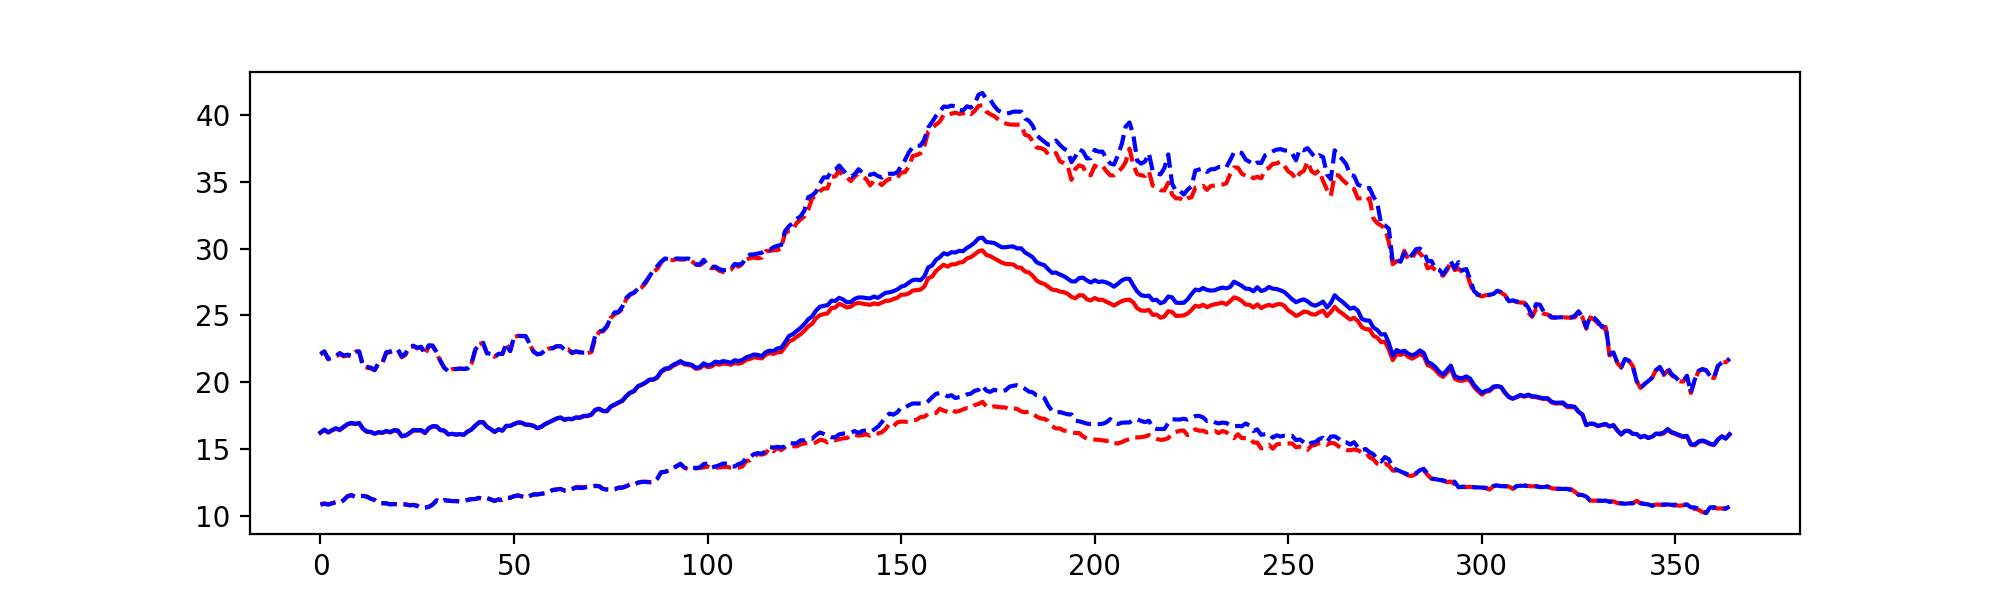

In [8]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(int_daily_mean, color ='red')
plt.plot(int_daily_bounds[:,0], color ='red', linestyle='--')
plt.plot(int_daily_bounds[:,1], color ='red', linestyle='--')
plt.plot(int_1_daily_mean,color='blue')
plt.plot(int_1_daily_bounds[:,0], color ='blue', linestyle='--')
plt.plot(int_1_daily_bounds[:,1], color ='blue', linestyle='--')


In [9]:
## OUTPUT AS NETCDF ##
## SAVE HOVMOLLER DIAGRAMS OF MEAN INTENSITY AND STANDARD DEVIATION ##
outfilename = "RDA_int_climo.nc"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
fullname = ferretpath + outfilename

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(fullname):
    os.remove(fullname)
    
outfile = nc.Dataset(fullname, 'w')

#use same years as chosen above:
#yr_beg = [1951,1951,1980,1980,1994]
#yr_end = [2007,1979,2007,1993,2007]

#create dimensions in NetCDF file
days_dim = outfile.createDimension('time', None)
lat_dim = outfile.createDimension('lat', 22)
dim_tuple = ("time","lat")

#run through each set of time periods
for i, (yr_b, yr_e) in enumerate(zip(yr_beg, yr_end)):
    
    #convoluted line of code below guarantees that 2007 will become '07' and not '7'
    years = str(yr_b-1900) + str("{0:0=2d}".format((yr_e-1900)%100))
    print(years)

    #create variables inside netCDF file
    int_1_mean_out = outfile.createVariable("int_1_mean_" + years, 'f8', dim_tuple)
    int_2_mean_out = outfile.createVariable("int_2_mean_" + years, 'f8', dim_tuple)
    int_mean_out = outfile.createVariable("int_mean_" + years, 'f8', dim_tuple)
    
    int_1_std_out = outfile.createVariable("int_1_std_" + years, 'f8', dim_tuple)
    int_2_std_out = outfile.createVariable("int_2_std_" + years, 'f8', dim_tuple)
    int_std_out = outfile.createVariable("int_std_" + years, 'f8', dim_tuple)
    
    int_1_stdofmean_out = outfile.createVariable("int_1_stdofmean_" + years, 'f8', dim_tuple)
    int_2_stdofmean_out = outfile.createVariable("int_2_stdofmean_" + years, 'f8', dim_tuple)
    int_stdofmean_out = outfile.createVariable("int_stdofmean_" + years, 'f8', dim_tuple)

    #fill with actual values
    int_1_mean_out[:] = ints_1_mean_mask[i]
    int_2_mean_out[:] = ints_2_mean_mask[i]
    int_mean_out[:] = ints_mean_mask[i]
    
    int_1_std_out[:] = ints_1_std_mask[i]
    int_2_std_out[:] = ints_2_std_mask[i]
    int_std_out[:] = ints_std_mask[i]
    
    int_1_stdofmean_out[:] = ints_1_stdofmean_mask[i]
    int_2_stdofmean_out[:] = ints_2_stdofmean_mask[i]
    int_stdofmean_out[:] = ints_stdofmean_mask[i]
    
### add a few new climo variables
int_1_climo_mean = outfile.createVariable("int_1_climo_mean", 'f8', "time")
int_climo_mean = outfile.createVariable("int_climo_mean", 'f8', "time")

int_1_climo_ub = outfile.createVariable("int_1_climo_ub", 'f8', "time")
int_climo_ub = outfile.createVariable("int_climo_ub", 'f8', "time")

int_1_climo_lb = outfile.createVariable("int_1_climo_lb", 'f8', "time")
int_climo_lb = outfile.createVariable("int_climo_lb", 'f8', "time")

int_1_climo_mean[:] = int_1_daily_mean
int_climo_mean[:] = int_daily_mean

int_1_climo_lb[:] = int_1_daily_bounds[:,0]
int_climo_lb[:] = int_daily_bounds[:,0]

int_1_climo_ub[:] = int_1_daily_bounds[:,1]
int_climo_ub[:] = int_daily_bounds[:,1]

outfile.close()

5107
5179
8007
8093
9407


In [10]:
print(ints_2_mean_mask[0][:,10])

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 11.189996229635703
 11.189996229635703 11.189996229635703 11.189996229635703
 11.189996229635703 11.189996229635703 11.189996229635703
 11.189996229635703 11.189996229635703 11.189996229635703
 11.189996229635703 11.189996229635703 11.189996229635703
 11.189996229635703 11.189996229635703 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 17.503152260413536 17.503152260413536 17.503152260413536
 17.503152260413536 17.503152260413536 17.503152260413536
 17.503152260413536 17.503152260413536 17.503152260413536
 17.503152260413536 17.503152260413536 17.503152260413536
 17.503152260413536 17.503152260413536 17.503152260413536 -- -- -- -- -- --
 -- -- -- -- -- -- 19.92071046412937 19.92071046412937 19.92071046412937
 19.92071046412937 19.92071046412937 19.92071046412937 19.92071046412937
 19.92071046412937 18.776922592284187 18.776922592284187 18.776922592284187
 18.776922592284187 18.77692259

<IPython.core.display.Javascript object>


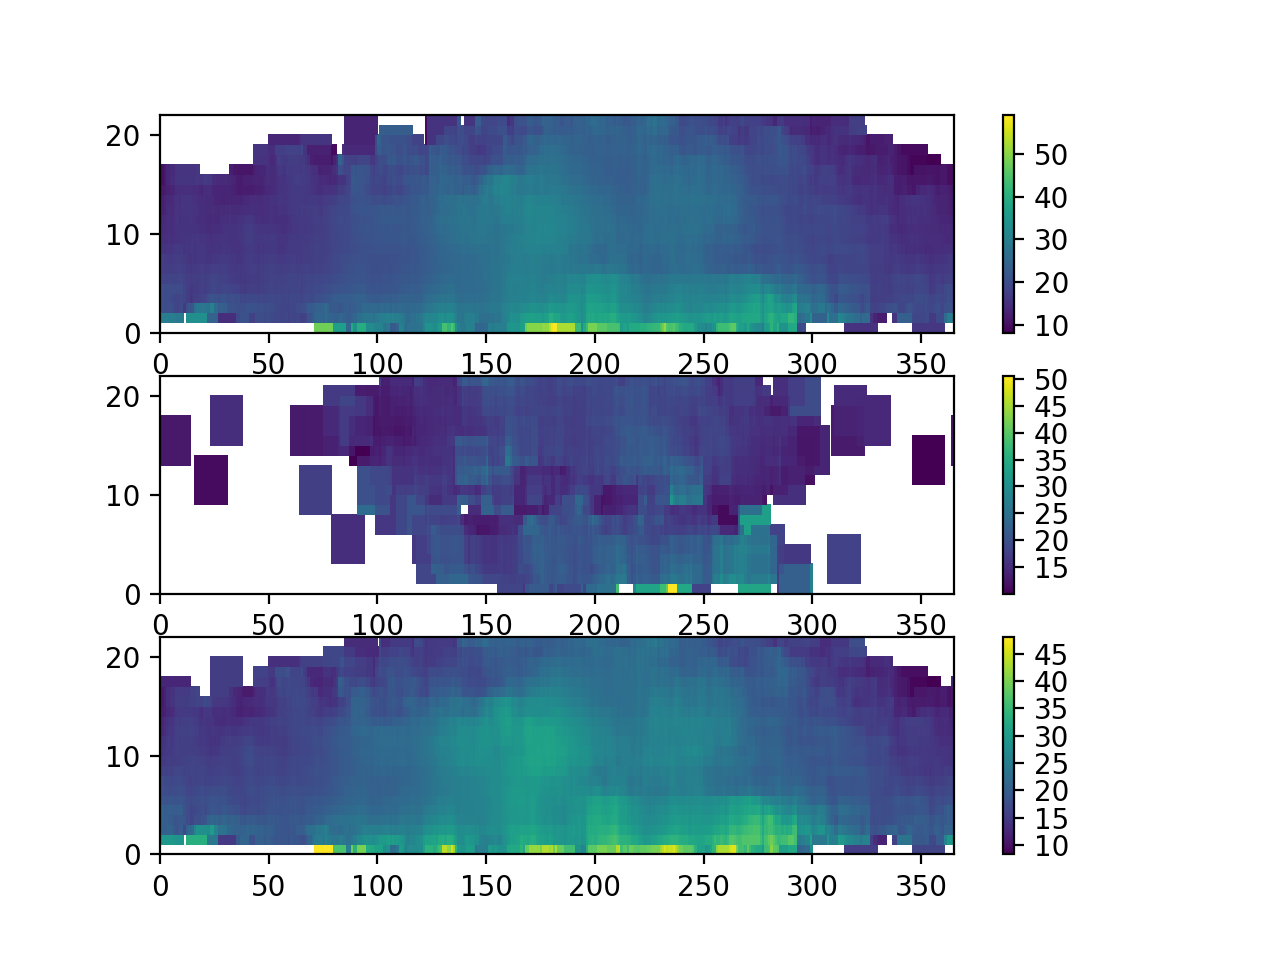

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(ints_1_mean_mask[0].T)
plt.colorbar()

ax2= fig.add_subplot(312)
plt.pcolormesh(ints_2_mean_mask[0].T)
plt.colorbar()

ax3 = fig.add_subplot(313)
plt.pcolormesh(ints_mean_mask[0].T)
plt.colorbar()

<IPython.core.display.Javascript object>


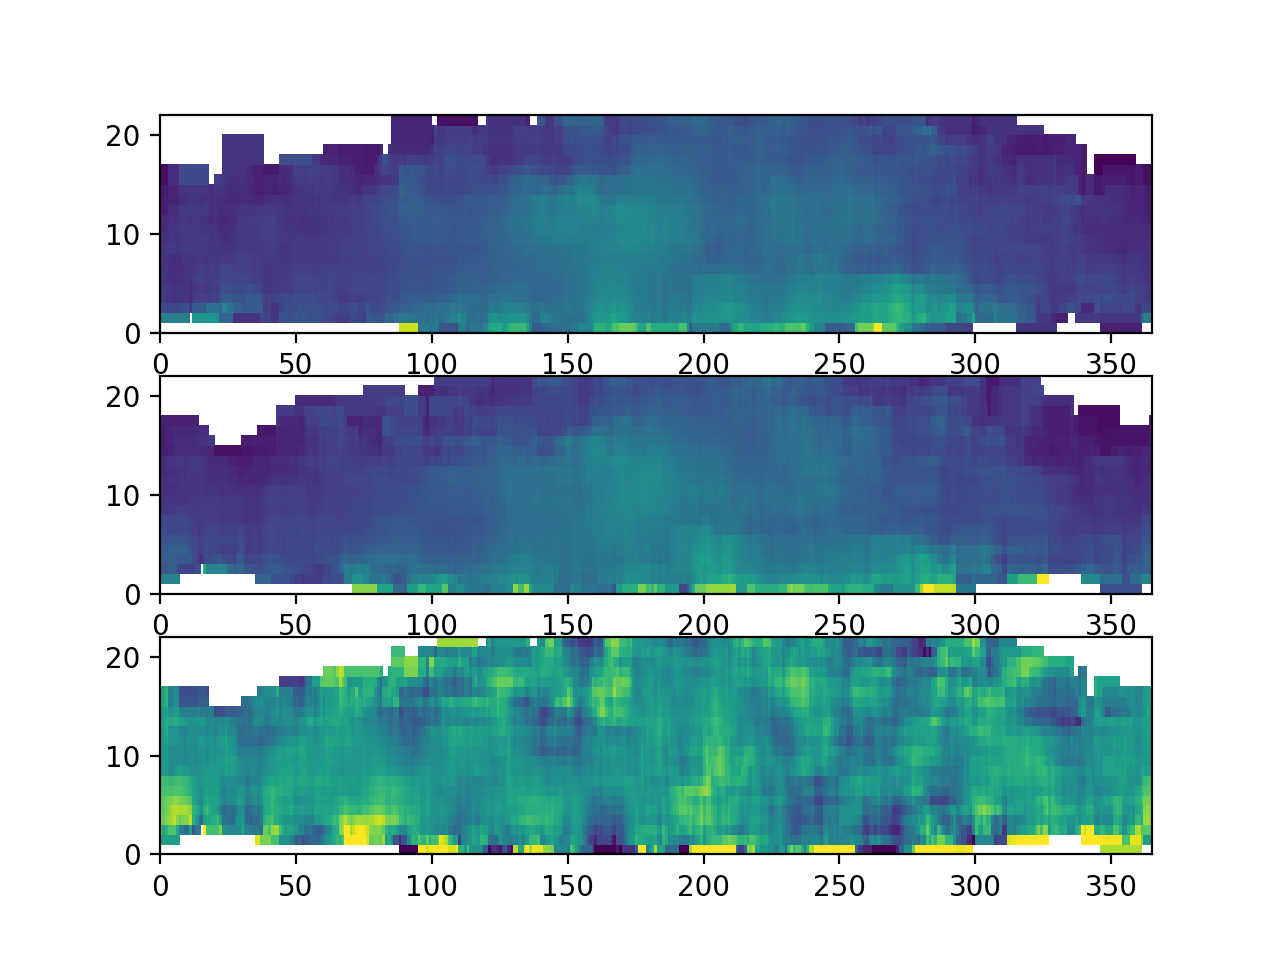

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(ints_mean_mask[1].T, vmin=8, vmax=57)

ax2= fig.add_subplot(312)
plt.pcolormesh(ints_mean_mask[2].T, vmin=8, vmax=57)

qq = ints_mean_mask[2].T-ints_mean_mask[1].T

ax3= fig.add_subplot(313)
plt.pcolormesh(qq, vmin = -10, vmax = 10)

<IPython.core.display.Javascript object>


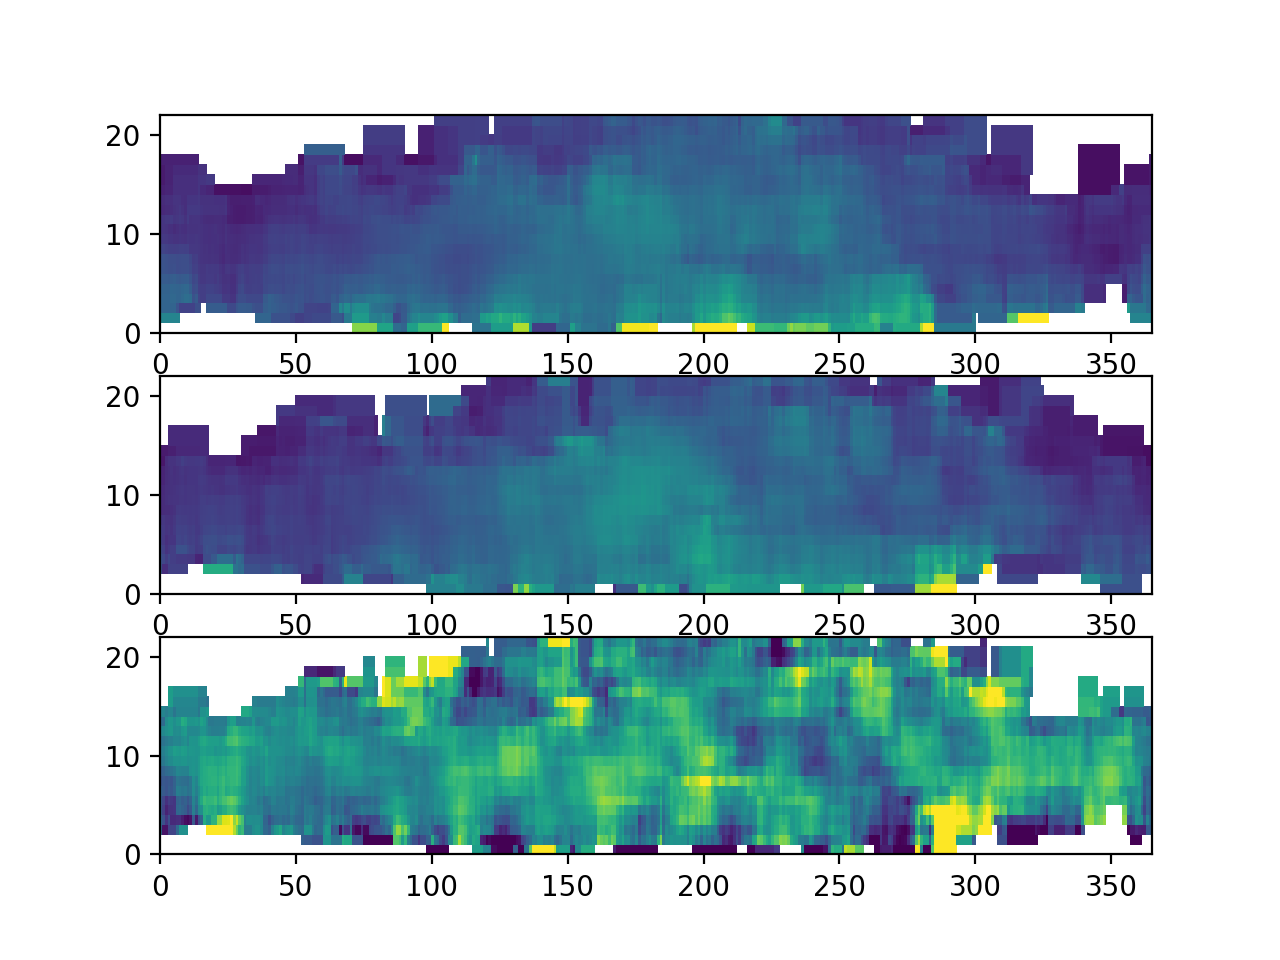

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(ints_mean_mask[3].T, vmin=8, vmax=57)

ax2= fig.add_subplot(312)
plt.pcolormesh(ints_mean_mask[4].T, vmin=8, vmax=57)

qq = ints_mean_mask[4].T-ints_mean_mask[3].T

ax3= fig.add_subplot(313)
plt.pcolormesh(qq, vmin = -10, vmax = 10)